In [1]:
import os
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.cm as cm

from keras.utils import to_categorical
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

Using TensorFlow backend.


device(type='cpu')

In [2]:
def duplicate(df, n) :
    df_result = pd.DataFrame()
    for c in df.columns :
        df_result[c] = df[c].repeat(n)
    df_result = df_result.reset_index(drop=True)
    return df_result

def pairing(df_base, df_additional) :
    n = len(df_base)
    df_base = duplicate(df_base, len(df_additional))
    df_base['LONGITUDE_SOURCE'] = pd.np.tile(df_additional.LONGITUDE, n) 
    df_base['LATITUDE_SOURCE'] = pd.np.tile(df_additional.LATITUDE, n) 
    df_base['SIGNAL_SOURCE'] = pd.np.tile(df_additional.SIGNAL, n) 
    return df_base

def merge_agg(df, group, value, aggregates, columns=None) :
    df_count = pd.DataFrame(df.groupby(group)[value].agg(aggregates)).reset_index()
    df_count.columns = group + aggregates if columns is None else group + columns
    df = df.merge(df_count, on=group, how="left").fillna(0)
    return df

def restructure(df) :
    df_final = pd.DataFrame()
    for i in range(1,521) :
        AP = 'WAP%03d' % i
        df_temp = df[[AP, 'LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']]
        df_temp = df_temp.rename(columns={AP : 'SIGNAL'})
        df_temp['WAP'] = i
        
        df_final = df_final.append(df_temp, ignore_index=True)
    df_final = df_final.drop_duplicates().reset_index(drop=True)
    return df_final

def get_strongest(df) :
    df_max = pd.DataFrame()
    for WAP in range(1,521) :
        df_temp = df[df['WAP'] == WAP].reset_index(drop=True)
        max_val = df_temp['SIGNAL'].max()
        
        df_temp = df_temp[df_temp['SIGNAL'] == max_val]
        df_temp = df_temp.drop_duplicates().reset_index(drop=True)
        
        df_max = df_max.append(df_temp).reset_index(drop=True)

    return df_max
    
    
def generate(df, df_max, building_id, floor):
    curr_df = df[(df['BUILDINGID']==building_id) & (df['FLOOR']==floor)].reset_index(drop=True)
    curr_df_max = df_max[(df_max['BUILDINGID']==building_id) & (df_max['FLOOR']==floor)].reset_index(drop=True)
    max_curr_floor = curr_df_max['WAP'].unique()

    df_final = pd.DataFrame()
    for i in max_curr_floor :
        df_temp = curr_df[curr_df['WAP']==i][['WAP', 'LONGITUDE', 'LATITUDE', 'SIGNAL']]

        #add pairing
        curr_df_max_by_WAP = curr_df_max[curr_df_max['WAP']==i]
        df_temp = pairing(df_temp, curr_df_max_by_WAP)
        df_temp['DIFF_SIGNAL'] = df_temp['SIGNAL_SOURCE'] - df_temp['SIGNAL']

        df_final = df_final.append(df_temp, ignore_index=True)

    return df_final, curr_df_max

In [3]:
# df_train = pd.DataFrame.from_csv('../data/ujiindoorloc/trainingData.csv').reset_index()
# df_val = pd.DataFrame.from_csv('../data/ujiindoorloc/validationData.csv').reset_index()

# df_restructure_train = restructure(df_train)
# df_restructure_train.to_csv('../data/ujiindoorloc/restructured_train.csv')
# df_restructure_val = restructure(df_val)
# df_restructure_val.to_csv('../data/ujiindoorloc/restructured_val.csv')

# df_restructure = df_restructure_train.append(df_restructure_val, ignore_index=True)
# df_restructure.to_csv('../data/ujiindoorloc/restructured_all.csv')

df_restructure_train = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_train.csv')
# df_restructure_val = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_val.csv')
# df_restructure = pd.DataFrame.from_csv('../data/ujiindoorloc/restructured_all.csv')

df_restructure_train['LONGITUDE'] = minmax_scale(df_restructure_train['LONGITUDE'], feature_range=(-1, 1))
df_restructure_train['LATITUDE'] = minmax_scale(df_restructure_train['LATITUDE'], feature_range=(-1, 1))

# df_restructure['LONGITUDE'] = minmax_scale(df_restructure['LONGITUDE'], feature_range=(-1, 1))
# df_restructure['LATITUDE'] = minmax_scale(df_restructure['LATITUDE'], feature_range=(-1, 1))

# df_restructure_val['LONGITUDE'] = minmax_scale(df_restructure_val['LONGITUDE'], feature_range=(-1, 1))
# df_restructure_val['LATITUDE'] = minmax_scale(df_restructure_val['LATITUDE'], feature_range=(-1, 1))

/home/tryan/miniconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  if sys.path[0] == '':


In [4]:
print('dataset len ', len(df_restructure_train[['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']].drop_duplicates()))
for bid in range(3) :
    for fid in range(5) :
        temp = df_restructure_train[(df_restructure_train.BUILDINGID==bid)&(df_restructure_train.FLOOR==fid)]
        print(bid, fid, 'locations: ', len(temp[['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']].drop_duplicates()))

dataset len  933
0 0 locations:  54
0 1 locations:  67
0 2 locations:  70
0 3 locations:  68
0 4 locations:  0
1 0 locations:  76
1 1 locations:  60
1 2 locations:  79
1 3 locations:  50
1 4 locations:  0
2 0 locations:  67
2 1 locations:  89
2 2 locations:  73
2 3 locations:  113
2 4 locations:  67


In [5]:
group = ['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR', 'WAP']
df_agg_max = merge_agg(df_restructure_train, group, 'SIGNAL', ['max'], ['MAX'])

In [6]:
df_detected = df_agg_max[df_agg_max['MAX']<100].drop('MAX', axis=1)
df_detected['SIGNAL'] = minmax_scale(df_detected['SIGNAL'], feature_range=(-1, 1))

In [7]:
df_detected = merge_agg(df_detected, group, 'SIGNAL', ['mean'])
df_detected = df_detected.drop('SIGNAL', axis=1).rename(columns={'mean' : 'SIGNAL'})
df_detected = df_detected.drop_duplicates().reset_index(drop=True)

In [8]:
df_max = get_strongest(df_detected)

In [9]:
wap_count = {}
print('all len ', len(df_max.WAP.unique()))
for bid in range(3) :
    wap_count[bid] = {}
    for fid in range(5) :
        temp = df_max[(df_max.BUILDINGID==bid)&(df_max.FLOOR==fid)]
        print(bid, fid, 'WAP source :', len(temp.WAP.unique()))  
        wap_count[bid][fid] = len(temp.WAP.unique()) 

all len  259
0 0 WAP source : 11
0 1 WAP source : 19
0 2 WAP source : 14
0 3 WAP source : 12
0 4 WAP source : 0
1 0 WAP source : 61
1 1 WAP source : 23
1 2 WAP source : 22
1 3 WAP source : 18
1 4 WAP source : 0
2 0 WAP source : 13
2 1 WAP source : 15
2 2 WAP source : 14
2 3 WAP source : 16
2 4 WAP source : 21


In [10]:
for bid in range(3) :
    for fid in range(5) :
        if fid==4 and bid!=2 :
            continue
            
        max_curr_floor = df_max[(df_max['BUILDINGID']==bid) & (df_max['FLOOR']==fid)]['WAP'].unique()
        temp = df_agg_max[(df_agg_max.BUILDINGID==bid)&(df_agg_max.FLOOR==fid)&(df_agg_max.WAP.isin(max_curr_floor))]
        temp = temp[['LONGITUDE', 'LATITUDE', 'WAP', 'MAX']].drop_duplicates()
        
        temp_c = temp[temp.MAX<100]
        temp_c_l = temp_c[['LONGITUDE', 'LATITUDE']].drop_duplicates()
        
        temp_ch = temp[temp.MAX==100].groupby(['LONGITUDE', 'LATITUDE']).count()
        temp_ch = temp_ch[temp_ch.WAP==wap_count[bid][fid]]
        
        print(bid, fid, 'all data:', len(temp), 'detected data:', len(temp_c), 
              'detected locs:', len(temp_c_l), 'coverage hole:', len(temp_ch))

0 0 all data: 594 detected data: 129 detected locs: 47 coverage hole: 7
0 1 all data: 1273 detected data: 268 detected locs: 66 coverage hole: 1
0 2 all data: 980 detected data: 159 detected locs: 60 coverage hole: 10
0 3 all data: 816 detected data: 268 detected locs: 67 coverage hole: 1
1 0 all data: 4636 detected data: 475 detected locs: 76 coverage hole: 0
1 1 all data: 1380 detected data: 220 detected locs: 58 coverage hole: 2
1 2 all data: 1738 detected data: 290 detected locs: 79 coverage hole: 0
1 3 all data: 900 detected data: 113 detected locs: 33 coverage hole: 17
2 0 all data: 871 detected data: 162 detected locs: 50 coverage hole: 17
2 1 all data: 1335 detected data: 244 detected locs: 85 coverage hole: 4
2 2 all data: 1022 detected data: 241 detected locs: 72 coverage hole: 1
2 3 all data: 1808 detected data: 365 detected locs: 112 coverage hole: 1
2 4 all data: 1407 detected data: 445 detected locs: 67 coverage hole: 0


In [28]:
bid, fid = 2, 3
df_data, curr_df_max = generate(df_detected, df_max, building_id=bid, floor=fid)
train_data, val_data = train_test_split(df_data, test_size=0.2, random_state=42)
print(bid, fid, 'train point', len(train_data), 'val point', len(val_data))

2 3 train point 292 val point 73


In [77]:
colors = cm.rainbow(np.linspace(0, 1, len(df_data.WAP.unique())))
color_dict = {i:c for i, c in zip(df_data.WAP.unique(), colors)}
color_wap = [color_dict[x] for x in df_data.WAP]

In [30]:
class UJIIndoorLocDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.features = self.df.drop(['WAP', 'SIGNAL', 'SIGNAL_SOURCE', 'DIFF_SIGNAL'], axis=1).values
        self.labels = self.df['DIFF_SIGNAL'].values 

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx,:2], self.features[idx,2:], self.labels[idx]
#         return self.features[idx], self.labels[idx]

In [31]:
batch_size = 64
all_dataset = UJIIndoorLocDataset(df_data)
all_dataloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)
all_dataset.__len__()

365

In [32]:
# https://github.com/L1aoXingyu/pytorch-beginner/tree/master/08-AutoEncoder
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.Dropout(0.2),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3))

    def forward(self, x1, x2=None, predict=False):
        out1 = self.encoder(x1)
        
        if predict :
            return out1
        
        out2 = self.encoder(x2)
        distance = torch.sqrt(torch.sum((out1 - out2)**2, dim=1))
        return distance

In [69]:
num_epochs = 100
learning_rate = 1e-1
learning_rate = 1e-1
model = autoencoder().to(device).float()
criterion = nn.MSELoss().to(device)

def exp_lr_scheduler(optimizer, epoch, lr_decay=0.1, lr_decay_epoch=5):
    if epoch % lr_decay_epoch:
        for param_group in optimizer.param_groups:
            new_lr = param_group['lr'] / (1+lr_decay*epoch)
            param_group['lr'] = new_lr
    return optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
optimizer = exp_lr_scheduler(optimizer, num_epochs, lr_decay=1e-2, lr_decay_epoch=10)
optimizer = exp_lr_scheduler(optimizer, num_epochs, lr_decay=1e-1, lr_decay_epoch=5)

# Train the model 

In [70]:
losses = []
min_loss = 1
best_model = model
for epoch in range(num_epochs):
    for features1, features2, labels in all_dataloader:
        features1 = features1.to(device)
        features2 = features2.to(device)
        labels = labels.to(device)
        # ===================forward=====================
        distance = model(features1.float(), features2.float())
        loss = criterion(distance, labels.float())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    losses.append(loss.item())
    
    if losses[-1] < min_loss :
        min_loss = losses[-1]
        best_model = copy.deepcopy(model) 

print(bid, fid, 'model loss start {:.4f} best {:.4f}'.format(losses[1], min_loss))

2 4 model loss start 0.1985 best 0.0399


<function matplotlib.pyplot.show(*args, **kw)>

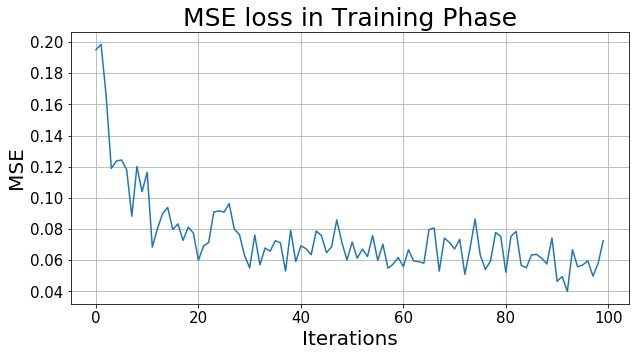

In [71]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Iterations', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tick_params(labelsize=15)
plt.title('MSE loss in Training Phase', fontsize=25)
plt.grid(True)
plt.show

In [72]:
best_model.eval()

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Dropout(p=0.2)
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

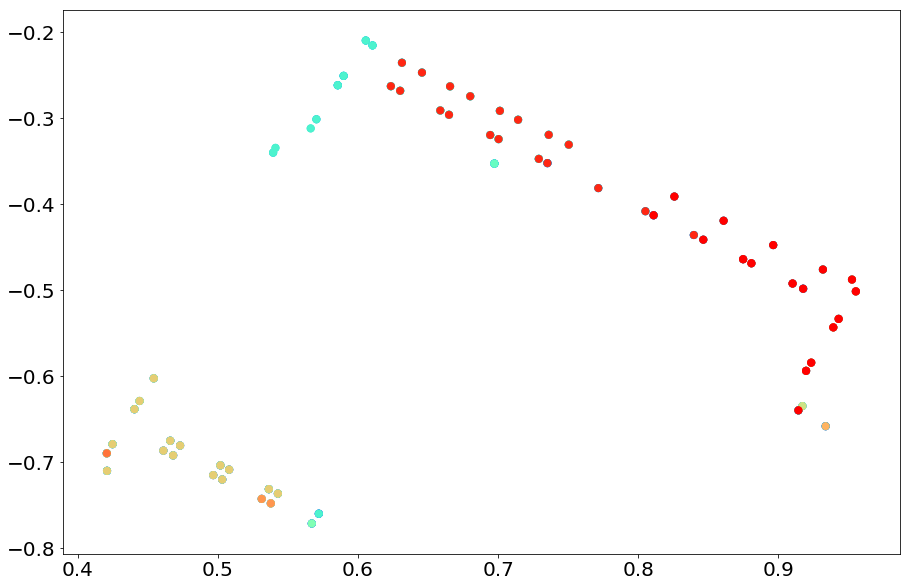

Text(0.5, 0, 'z')

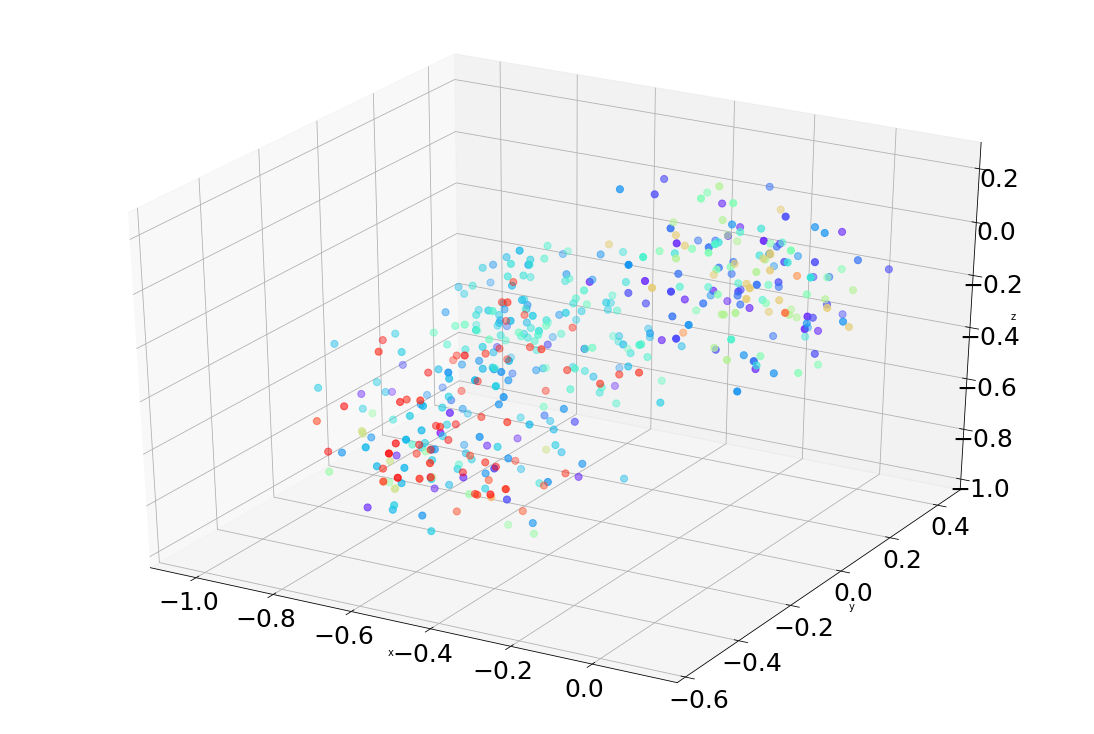

In [73]:
# http://www.analyzingdata.org/portfolio/003-Indoor_localization_Wifi_Footprint/
x = df_data['LONGITUDE']
y = df_data['LATITUDE']
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
ax.scatter(x, y, c=color_wap, s=50)

features = df_data[['LONGITUDE', 'LATITUDE']].values
features = torch.tensor(features).to(device).float()
out = model(features, predict=True)
out = out.cpu().detach().numpy()

# for i in range(len(out)) :
#     ax.annotate(i, (x[i], y[i]), fontsize=5)
plt.show()

fig = plt.figure(figsize=(15,10))
ax = Axes3D(fig)
ax.tick_params(labelsize=25)

ax.scatter(out[:, 0], out[:, 1], out[:, 2], c=color_wap, s=50)
# for i, x in zip(range(len(out)), df_data.WAP) :
#     ax.text(out[i, 0], out[i, 1], out[i, 2],i, fontsize=5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [74]:
max_curr_floor = curr_df_max['WAP'].unique()
curr_coverage = df_agg_max[(df_agg_max.BUILDINGID==bid)&(df_agg_max.FLOOR==fid)&(df_agg_max.WAP.isin(max_curr_floor))]
curr_coverage = curr_coverage[['LONGITUDE', 'LATITUDE', 'WAP', 'MAX']]
curr_coverage = curr_coverage.drop_duplicates().reset_index(drop=True)

curr_coverage_hole = curr_coverage[curr_coverage['MAX']==100]
curr_coverage_hole = curr_coverage_hole.groupby(['LONGITUDE', 'LATITUDE']).count()
curr_coverage_hole = curr_coverage_hole['MAX'].reset_index()

2 4 vote mse 7.522388059701493 vote mae 2.208955223880597


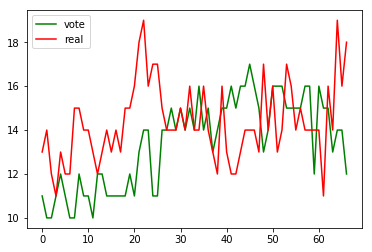

In [75]:
locs = ['LONGITUDE', 'LATITUDE']
detected_locations = curr_coverage[['LONGITUDE', 'LATITUDE']].drop_duplicates().reset_index(drop=True)

for i in max_curr_floor :
    curr_df = curr_coverage[curr_coverage.WAP == i].copy()
    features = curr_df[locs].values
    features = torch.tensor(features).to(device).float()

    source = curr_df_max[curr_df_max.WAP==i][locs].values[0]
    sources = np.tile(source, (len(features), 1))
    sources = torch.tensor(sources).to(device).float()

    out = model(features,sources)
    out = out.cpu().detach().numpy()
    curr_df['DISTANCE'] = out

    detected = curr_df[(curr_df.MAX<100)]
    lon_min, lon_max = detected.LONGITUDE.min(), detected.LONGITUDE.max()
    lat_min, lat_max = detected.LATITUDE.min(), detected.LATITUDE.max()
    max_distance = 1*detected['DISTANCE'].max()

    real_hole = curr_df[curr_df.MAX==100]
    hole_candidate = curr_df[curr_df['DISTANCE']>max_distance]

    hole_candidate_locations = hole_candidate[locs].drop_duplicates().reset_index(drop=True)
    hole_candidate_locations[i] = 0
    detected_locations = detected_locations.merge(hole_candidate_locations, on=locs, how="left").fillna(1)

detected_locations['vote'] = detected_locations.iloc[:, 2:].sum(axis=1)
detected_locations = detected_locations.merge(curr_coverage_hole, on=locs, how="left").fillna(0)
print(bid, fid, 'vote mse', mean_squared_error(detected_locations['vote'], detected_locations['MAX']), 
      'vote mae', mean_absolute_error(detected_locations['vote'], detected_locations['MAX']))

plt.plot(detected_locations['vote'], 'g', label='vote')
plt.plot(detected_locations['MAX'], 'r', label='real')
plt.legend()
plt.show()

# Loop 

dataset len  933
0 0 locations:  54
0 0 WAP source : 11
0 0 all data: 594 detected data: 129 detected locs: 47 coverage hole: 7
0 0 train point 103 val point 26
0 0 model loss start 0.1367 best 0.0000
0 0 vote mse 31.666666666666668 vote mae 5.333333333333333


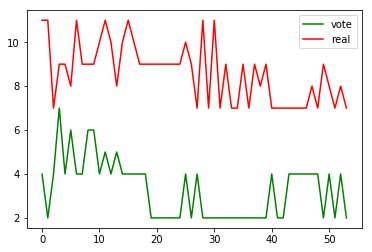



0 1 locations:  67
0 1 WAP source : 19
0 1 all data: 1273 detected data: 268 detected locs: 66 coverage hole: 1
0 1 train point 214 val point 54
0 1 model loss start 0.1030 best 0.0198
0 1 vote mse 103.14925373134328 vote mae 9.686567164179104


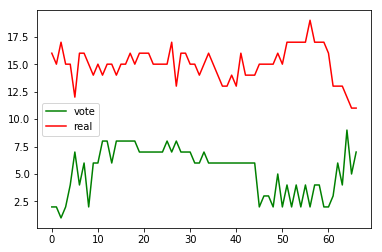



0 2 locations:  70
0 2 WAP source : 14
0 2 all data: 980 detected data: 159 detected locs: 60 coverage hole: 10
0 2 train point 127 val point 32
0 2 model loss start 0.0816 best 0.0297
0 2 vote mse 94.48571428571428 vote mae 9.428571428571429


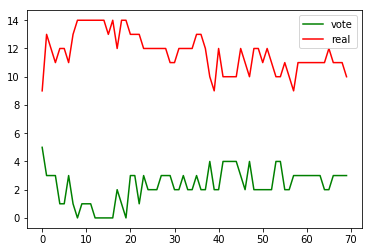



0 3 locations:  68
0 3 WAP source : 12
0 3 all data: 816 detected data: 268 detected locs: 67 coverage hole: 1
0 3 train point 214 val point 54
0 3 model loss start 0.0677 best 0.0099
0 3 vote mse 10.264705882352942 vote mae 2.764705882352941


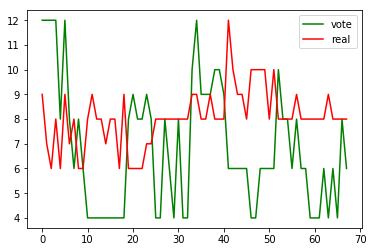



_________________________________________________________
1 0 locations:  76
1 0 WAP source : 61
1 0 all data: 4636 detected data: 475 detected locs: 76 coverage hole: 0
1 0 train point 380 val point 95
1 0 model loss start 0.0980 best 0.0131
1 0 vote mse 2122.184210526316 vote mae 43.60526315789474


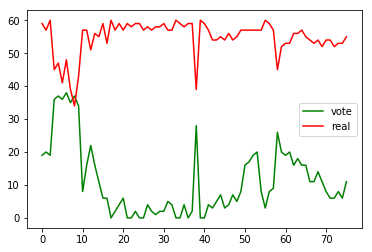



1 1 locations:  60
1 1 WAP source : 23
1 1 all data: 1380 detected data: 220 detected locs: 58 coverage hole: 2
1 1 train point 246 val point 62
1 1 model loss start 0.0715 best 0.0305
1 1 vote mse 209.5 vote mae 14.233333333333333


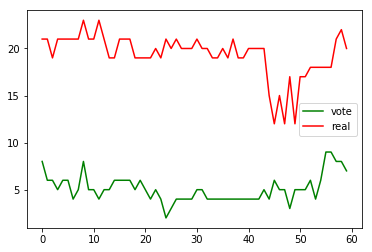



1 2 locations:  79
1 2 WAP source : 22
1 2 all data: 1738 detected data: 290 detected locs: 79 coverage hole: 0
1 2 train point 232 val point 58
1 2 model loss start 0.1926 best 0.0387
1 2 vote mse 177.7594936708861 vote mae 13.177215189873417


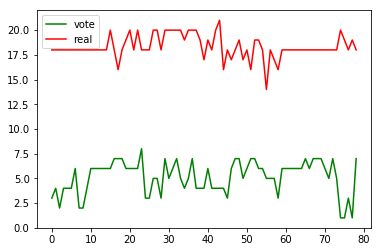



1 3 locations:  50
1 3 WAP source : 18
1 3 all data: 900 detected data: 113 detected locs: 33 coverage hole: 17
1 3 train point 90 val point 23
1 3 model loss start 0.0691 best 0.0260
1 3 vote mse 174.24 vote mae 12.84


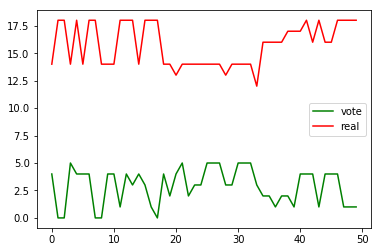



_________________________________________________________
2 0 locations:  67
2 0 WAP source : 13
2 0 all data: 871 detected data: 162 detected locs: 50 coverage hole: 17
2 0 train point 129 val point 33
2 0 model loss start 0.0980 best 0.0256
2 0 vote mse 29.0 vote mae 4.970149253731344


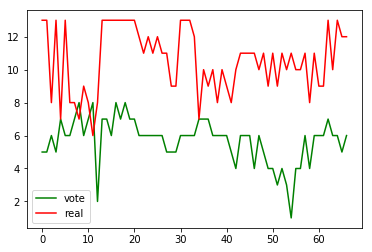



2 1 locations:  89
2 1 WAP source : 15
2 1 all data: 1335 detected data: 244 detected locs: 85 coverage hole: 4
2 1 train point 195 val point 49
2 1 model loss start 0.1323 best 0.0370
2 1 vote mse 63.26966292134831 vote mae 7.786516853932584


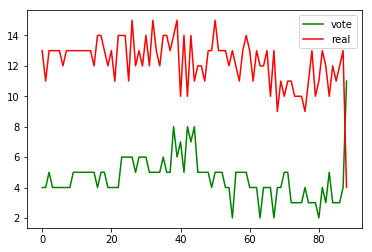



2 2 locations:  73
2 2 WAP source : 14
2 2 all data: 1022 detected data: 241 detected locs: 72 coverage hole: 1
2 2 train point 192 val point 49


In [ ]:
print('dataset len ', len(df_restructure_train[['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']].drop_duplicates()))
maes = []
mses = []
for bid in range(3) :
    for fid in range(5) :
        if fid==4 and bid!=2 :
            continue
        
        temp = df_restructure_train[(df_restructure_train.BUILDINGID==bid)&(df_restructure_train.FLOOR==fid)]
        print(bid, fid, 'locations: ', len(temp[['LONGITUDE', 'LATITUDE', 'BUILDINGID', 'FLOOR']].drop_duplicates()))
        
        temp = df_max[(df_max.BUILDINGID==bid)&(df_max.FLOOR==fid)]
        print(bid, fid, 'WAP source :', len(temp.WAP.unique())) 
                    
        max_curr_floor = df_max[(df_max['BUILDINGID']==bid) & (df_max['FLOOR']==fid)]['WAP'].unique()
        temp = df_agg_max[(df_agg_max.BUILDINGID==bid)&(df_agg_max.FLOOR==fid)&(df_agg_max.WAP.isin(max_curr_floor))]
        temp = temp[['LONGITUDE', 'LATITUDE', 'WAP', 'MAX']].drop_duplicates()
        
        temp_c = temp[temp.MAX<100]
        temp_c_l = temp_c[['LONGITUDE', 'LATITUDE']].drop_duplicates()
        
        temp_ch = temp[temp.MAX==100].groupby(['LONGITUDE', 'LATITUDE']).count()
        temp_ch = temp_ch[temp_ch.WAP==wap_count[bid][fid]]
        
        print(bid, fid, 'all data:', len(temp), 'detected data:', len(temp_c), 
              'detected locs:', len(temp_c_l), 'coverage hole:', len(temp_ch))
        
        df_data, curr_df_max = generate(df_detected, df_max, building_id=bid, floor=fid)
        train_data, val_data = train_test_split(df_data, test_size=0.2, random_state=42)
        print(bid, fid, 'train point', len(train_data), 'val point', len(val_data))
        
        all_dataset = UJIIndoorLocDataset(df_data)
        all_dataloader = DataLoader(all_dataset, batch_size=batch_size, shuffle=True)

        num_epochs = 100
        learning_rate = 1e-1
        model = autoencoder().to(device).float()
        criterion = nn.MSELoss().to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-2)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        optimizer = exp_lr_scheduler(optimizer, num_epochs, lr_decay=1e-2, lr_decay_epoch=10)
        
        losses = []
        min_loss = 1
        best_model = model
        for epoch in range(num_epochs):
            for features1, features2, labels in all_dataloader:
                features1 = features1.to(device)
                features2 = features2.to(device)
                labels = labels.to(device)
                # ===================forward=====================
                distance = model(features1.float(), features2.float())
                loss = criterion(distance, labels.float())
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            # ===================log========================
            losses.append(loss.item())
            if losses[-1]<min_loss :
                min_loss = losses[-1]
                best_model = copy.deepcopy(model)
            
        print(bid, fid, 'model loss start {:.4f} best {:.4f}'.format(losses[1], min_loss))
        best_model.eval()
        
        max_curr_floor = curr_df_max['WAP'].unique()
        curr_coverage = df_agg_max[(df_agg_max.BUILDINGID==bid)&(df_agg_max.FLOOR==fid)&(df_agg_max.WAP.isin(max_curr_floor))]
        curr_coverage = curr_coverage[['LONGITUDE', 'LATITUDE', 'WAP', 'MAX']]
        curr_coverage = curr_coverage.drop_duplicates().reset_index(drop=True)

        curr_coverage_hole = curr_coverage[curr_coverage['MAX']==100]
        curr_coverage_hole = curr_coverage_hole.groupby(['LONGITUDE', 'LATITUDE']).count()
        curr_coverage_hole = curr_coverage_hole['MAX'].reset_index()        
        
        locs = ['LONGITUDE', 'LATITUDE']
        detected_locations = curr_coverage[['LONGITUDE', 'LATITUDE']].drop_duplicates().reset_index(drop=True)

        for i in max_curr_floor :
            curr_df = curr_coverage[curr_coverage.WAP == i].copy()
            features = curr_df[locs].values
            features = torch.tensor(features).to(device).float()

            source = curr_df_max[curr_df_max.WAP==i][locs].values[0]
            sources = np.tile(source, (len(features), 1))
            sources = torch.tensor(sources).to(device).float()

            out = best_model(features,sources)
            out = out.cpu().detach().numpy()
            curr_df['DISTANCE'] = out

            detected = curr_df[(curr_df.MAX<100)]
            lon_min, lon_max = detected.LONGITUDE.min(), detected.LONGITUDE.max()
            lat_min, lat_max = detected.LATITUDE.min(), detected.LATITUDE.max()
            max_distance = 0.8*detected['DISTANCE'].max()

            real_hole = curr_df[curr_df.MAX==100]
            hole_candidate = curr_df[curr_df['DISTANCE']>max_distance]

            hole_candidate_locations = hole_candidate[locs].drop_duplicates().reset_index(drop=True)
            hole_candidate_locations[i] = 0
            detected_locations = detected_locations.merge(hole_candidate_locations, on=locs, how="left").fillna(1)
        
        detected_locations['vote'] = detected_locations.iloc[:, 2:].sum(axis=1)
        detected_locations = detected_locations.merge(curr_coverage_hole, on=locs, how="left").fillna(0)
        mses.append(mean_squared_error(detected_locations['vote'], detected_locations['MAX']))
        maes.append(mean_absolute_error(detected_locations['vote'], detected_locations['MAX']))
        print(bid, fid, 'vote mse', mses[-1], 
              'vote mae', maes[-1])
        
        plt.plot(detected_locations['vote'], 'g', label='vote')
        plt.plot(detected_locations['MAX'], 'r', label='real')
        plt.legend()
        plt.show()
        print('')
        print('')
    print('_________________________________________________________')

In [ ]:
maes